In [1]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random
import re
import unicodedata
import datetime
import itertools
%matplotlib inline

## Load data

In [196]:
def timestamp_to_datetime(timestamp):
    return datetime.date(timestamp.year, timestamp.month, timestamp.day)

In [197]:
g_dat = pd.read_excel('data/box_scores/box_score_2017.xlsx')

In [198]:
g_dat.head()

,ast,blk,drb,fg,fg3,fg3_pct,fg3a,fg_pct,fga,ft,...,stl_pct,tov_pct,trb_pct,ts_pct,usg_pct,g_num,g_id,team,date,season
0,0,2,3,5,3,0.60,5,0.385,13,3,...,1.5,11.3,11.0,0.512,22.7,1,201610250CLE,NYK,2016-10-25,2017
1,3,0,4,8,1,0.25,4,0.444,18,2,...,1.6,17.5,8.6,0.503,32.1,1,201610250CLE,NYK,2016-10-25,2017
2,1,1,1,7,1,0.50,2,0.412,17,2,...,0.0,18.3,5.2,0.475,31.2,1,201610250CLE,NYK,2016-10-25,2017
3,0,1,2,0,0,0.00,2,0.000,5,0,...,0.0,28.6,7.9,0.000,15.1,1,201610250CLE,NYK,2016-10-25,2017
4,3,0,5,0,0,NaN,0,0.000,1,0,...,2.5,50.0,15.9,0.000,4.3,1,201610250CLE,NYK,2016-10-25,2017


In [199]:
def fix_dates(df):
    df = df.reset_index()
    datetimes = []
    for timestamp in df['date']:
        datetimes.append(timestamp_to_datetime(timestamp))
    df['datetime'] = datetimes
    return df

In [200]:
# Weird discrepancy in excel changed datetimes to timestamps--change them back
g_dat = fix_dates(g_dat)

## Create Gini for each game

In [201]:
def get_reg_season(df, yr):
    return df[(df['datetime'] < datetime.date(yr,4,1)) | (df['g_num'] > 7)]

In [202]:
def get_playoffs(df, yr):
    return df[(df['datetime'] > datetime.date(yr,4,1)) & (df['g_num'] <= 7)]

In [203]:
def get_game(df, gid, team):
    return df[(df['g_id'] == gid) & (df['team'] == team)]

In [204]:
g_dat_reg = get_reg_season(g_dat, 2017)
g_dat_reg.head()

,index,ast,blk,drb,fg,fg3,fg3_pct,fg3a,fg_pct,fga,...,tov_pct,trb_pct,ts_pct,usg_pct,g_num,g_id,team,date,season,datetime
0,0,0,2,3,5,3,0.60,5,0.385,13,...,11.3,11.0,0.512,22.7,1,201610250CLE,NYK,2016-10-25,2017,2016-10-25
1,1,3,0,4,8,1,0.25,4,0.444,18,...,17.5,8.6,0.503,32.1,1,201610250CLE,NYK,2016-10-25,2017,2016-10-25
2,2,1,1,1,7,1,0.50,2,0.412,17,...,18.3,5.2,0.475,31.2,1,201610250CLE,NYK,2016-10-25,2017,2016-10-25
3,3,0,1,2,0,0,0.00,2,0.000,5,...,28.6,7.9,0.000,15.1,1,201610250CLE,NYK,2016-10-25,2017,2016-10-25
4,4,3,0,5,0,0,NaN,0,0.000,1,...,50.0,15.9,0.000,4.3,1,201610250CLE,NYK,2016-10-25,2017,2016-10-25


In [205]:
len(np.unique(g_dat['g_id']))

1309

In [206]:
# 1189 games played in the regular season--82 games each for 29 teams (divided by 2)
# 1230 games played in the regular season--82 games each for 30 teams (divided by 2)
len(np.unique(g_dat_reg['g_id']))

1230

In [207]:
game_dict = {tuple(game) for game in zip(g_dat_reg['g_id'], g_dat_reg['team'])}

In [208]:
# 2378 games--82 games each for 29 teams
# 2460 games--82 games each for 30 teams
len(game_dict)

2460

In [209]:
g_dat_reg[g_dat_reg['team'] == 'OKC'].head()

,index,ast,blk,drb,fg,fg3,fg3_pct,fg3a,fg_pct,fga,...,tov_pct,trb_pct,ts_pct,usg_pct,g_num,g_id,team,date,season,datetime
217,0,9,0,11,11,1,0.500,2,0.524,21,...,7.2,16.5,0.619,31.8,1,201610260PHI,OKC,2016-10-26,2017,2016-10-26
218,1,1,0,3,7,0,NaN,0,0.438,16,...,10.6,7.0,0.474,22.1,1,201610260PHI,OKC,2016-10-26,2017,2016-10-26
219,2,3,1,5,0,0,NaN,0,0.000,2,...,0.0,11.0,0.133,4.9,1,201610260PHI,OKC,2016-10-26,2017,2016-10-26
220,3,1,1,3,4,0,0.000,5,0.250,16,...,14.8,9.6,0.289,32.4,1,201610260PHI,OKC,2016-10-26,2017,2016-10-26
221,4,0,0,4,2,1,0.333,3,0.400,5,...,0.0,12.2,0.500,12.7,1,201610260PHI,OKC,2016-10-26,2017,2016-10-26


In [210]:
g_info = ('201610300OKC','OKC')

In [211]:
g1 = get_game(g_dat_reg, g_info[0], g_info[1])
adj_usg = [usg*(mp/60) for usg, mp in zip(g1['usg_pct'], g1['sec'])]
adj_usg_2 = [usg*((float(mp)/60)**2) for usg, mp in zip(g1['usg_pct'], g1['sec'])]
pd.DataFrame({'usg': g1['usg_pct'], 
              'min': [float(s)/60 for s in g1['sec']], 
              'adj_usg': adj_usg,
              'adj_usg_2': adj_usg_2})

,adj_usg,adj_usg_2,min,usg
864,950.0,36800.027778,38.366667,25.0
865,1188.0,40763.610000,33.650000,36.0
866,312.0,9391.226000,30.050000,10.4
867,577.1,17396.336778,29.566667,19.9
868,34.8,268.192000,6.800000,5.8
869,307.5,8113.493417,25.683333,12.3
870,491.4,11257.064000,21.933333,23.4
871,292.0,5888.768056,20.083333,14.6
872,196.2,3603.906361,18.183333,10.9
873,70.0,626.736111,7.916667,10.0


In [212]:
usg_adj = [usg*((float(mp)/60)**2) for usg, mp in zip(g1['usg_pct'], g1['sec'])]
print usg_adj
usg_norm = [u/sum(usg_adj) for u in usg_adj]
print usg_norm
print sum(usg_norm)

[36800.02777777778, 40763.61, 9391.226, 17396.33677777778, 268.19199999999995, 8113.493416666667, 11257.064, 5888.768055555554, 3603.9063611111114, 626.7361111111111, 1175.3630000000003, 166.66402777777776]
[0.2716843913483794, 0.3009464188149447, 0.06933281505199854, 0.12843232613036326, 0.0019799871001321434, 0.05989967002001205, 0.08310777914837858, 0.0434751401446361, 0.026606640410915223, 0.0046270187596460215, 0.00867737881060068, 0.0012304342599930842]
1.0


In [213]:
# df: the dataframe being used
# gid: the game id you want
# team: the team from that game you want
# n: the power raising minutes played to
def get_norm_usg(df, gid, team, n):
    game = get_game(df, gid, team)
    usg_adj = [usg*((float(mp)/60)**n) for usg, mp in zip(game['usg_pct'], game['sec'])]
    usg_norm = [u/sum(usg_adj) for u in usg_adj]
    return sorted(usg_norm)

In [214]:
n_usg = get_norm_usg(g_dat_reg, g_info[0], g_info[1], 2)

In [215]:
n_usg

[0.0012304342599930842,
 0.0019799871001321434,
 0.0046270187596460215,
 0.00867737881060068,
 0.026606640410915223,
 0.0434751401446361,
 0.05989967002001205,
 0.06933281505199854,
 0.08310777914837858,
 0.12843232613036326,
 0.2716843913483794,
 0.3009464188149447]

In [216]:
np.cumsum(n_usg)

array([ 0.00123043,  0.00321042,  0.00783744,  0.01651482,  0.04312146,
        0.0865966 ,  0.14649627,  0.21582908,  0.29893686,  0.42736919,
        0.69905358,  1.        ])

In [217]:
# n_usg: the normalized usage vector (sums to 1)
# k: how many players should be used in calculating gini
def get_norm_top_k(n_usg, k):
    new_usg = n_usg[-k:]
    return [u/sum(new_usg) for u in new_usg]

In [218]:
n_usg[-5:]

[0.06933281505199854,
 0.08310777914837858,
 0.12843232613036326,
 0.2716843913483794,
 0.3009464188149447]

In [219]:
n_usg_5 = get_norm_top_k(n_usg, 5)

In [220]:
n_usg_5

[0.0812331716603794,
 0.09737248494540299,
 0.15047658439174968,
 0.3183165833277735,
 0.35260117567469446]

In [221]:
print len(n_usg_5)
print sum(n_usg_5)

5
1.0


In [222]:
# For gini to be 1
#n_usg = [0]*20 + [1]
#n_usg

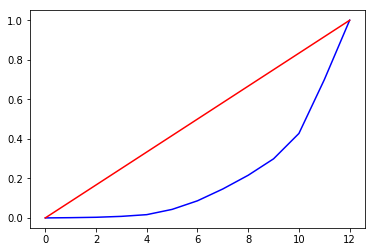

In [223]:
#x = [float(t)/(len(n_usg)) for t in range(len(n_usg)+1)]
x = range(len(n_usg)+1)
y1 = np.cumsum([0] + n_usg)
# For gini=1
#y1 = np.full(11,0)
#y1[len(y1)-1] = 1
y2 = [float(t)/(len(x)-1) for t in x]
#y2 = [float(t)/(len(n_usg)) for t in range(len(n_usg)+1)]
plt.plot(x, y1, c='b')
plt.plot(x, y2, c='r')
plt.show()

In [224]:
print np.trapz(y2), np.trapz(y1)

6.0 2.44619616229


In [225]:
area_under_curve = np.trapz(y1, dx=float(1)/len(y1)) #* len(y1)/(len(y1)-1)
print area_under_curve
# Multiply by 2 so the max is 1 and min is 0
print 'Gini:', round((1 - 2*area_under_curve) * len(y1)/(len(y1)-1), 3)

0.188168935561
Gini: 0.676


In [226]:
x[-1]*y1[-1]

11.999999999999996

In [227]:
2*(np.trapz(y2, x=x) - np.trapz(y1, x=x)) * len(n_usg)/(len(n_usg)-1)

7.7537538277322531

In [228]:
2 * (np.trapz(y2) - np.trapz(y1))

7.1076076754212316

In [229]:
# Multiply by constant so max is 1
2*(np.trapz(y2) - np.trapz(y1))/(x[-1]*y1[-1]) * len(n_usg)/(len(n_usg)-1)

0.64614615231102124

In [230]:
y1[-1]

0.99999999999999978

In [231]:
y1

array([ 0.        ,  0.00123043,  0.00321042,  0.00783744,  0.01651482,
        0.04312146,  0.0865966 ,  0.14649627,  0.21582908,  0.29893686,
        0.42736919,  0.69905358,  1.        ])

In [232]:
def get_gini_game(df, gid, team, k, n):
    norm_usg = get_norm_usg(df, gid, team, n)
    norm_usg_k = get_norm_top_k(norm_usg, k)
    x = range(len(norm_usg_k) + 1)
    y1 = np.cumsum([0] + norm_usg_k)
    y2 = [float(t)/(len(x)-1) for t in x]
    # area under curve times 2 multiplied by a constant to account for offset
    gini = 2*(np.trapz(y2) - np.trapz(y1))/(x[-1]*y1[-1]) * len(norm_usg_k)/(len(norm_usg_k)-1)
    return gini

In [233]:
g_info = ('201610300OKC','OKC')
gid = g_info[0]
team = g_info[1]
get_gini_game(g_dat_reg, gid, team, k=5, n=2)

print gid
print team
#gid = key[0]
#team = key[1]
temp_df = g_dat_reg[g_dat_reg['g_id'] == gid]
teams = list(np.unique(temp_df['team']))
teams.remove(team)

opponent = str(teams[0])
print opponent

game = get_game(g_dat_reg, gid, team)
date = game['datetime'].iloc[0]
print date
g_num = game['g_num'].iloc[0]
print g_num
gini = get_gini_game(g_dat_reg, gid, team, k=9, n=2)
print gini

201610300OKC
OKC
LAL
2016-10-30
3
0.528500061064


In [234]:
def plot_gini_game(df, gid, team, k, n):
    norm_usg = get_norm_usg(df, gid, team, n)
    norm_usg_k = get_norm_top_k(norm_usg, k)
    x = range(len(norm_usg_k) + 1)
    y1 = np.cumsum([0] + norm_usg_k)
    y2 = [float(t)/(len(x)-1) for t in x]
    # area under curve times 2 multiplied by a constant to account for offset
    gini = 2*(np.trapz(y2) - np.trapz(y1))/(x[-1]*y1[-1]) * len(norm_usg_k)/(len(norm_usg_k)-1)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    fig.subplots_adjust(top=0.85)
    ax.set_title('axes title')

    ax.set_xlabel('Player')
    ax.set_ylabel('Cumulative weighted usage')

    ax.text(1.5, 0.5, 'Gini: '+ str(round(gini,3)), fontsize=12)
    
    ax.plot(x, y1, c='black')
    ax.plot(x, y2, c='black')
    ax.fill_between(x, y1, y2, where=y2 >= y1, facecolor='b', interpolate=True)
    ax.set_title('Team: ' + team + ', Date: ' + gid[4:6] + '/' + gid[6:8] + '/' + gid[0:4])
    plt.show()

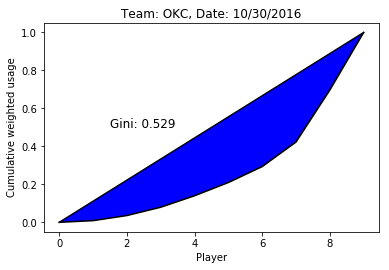

In [235]:
plot_gini_game(g_dat_reg, gid, team, k=9, n=2)

In [178]:
gini_log = pd.DataFrame()
gini_log = gini_log.append({'g_id': gid,
                            'team': team,
                            'opp': opponent,
                            'date': date,
                            'g_num': g_num,
                            'gini': gini},
                            ignore_index=True)

In [179]:
gini_log

,date,g_id,g_num,gini,opp,team
0,2016-10-30,201610300OKC,3.0,0.5285,LAL,OKC


In [183]:
def get_gini_season(df, n):
    game_dict = {tuple(game) for game in zip(df['g_id'], df['team'])}
    gini_log = pd.DataFrame()
    for key in game_dict:
        #print key
        gid = key[0]
        team = key[1]
        temp_df = df[df['g_id'] == gid]
        teams = list(np.unique(temp_df['team']))
        teams.remove(team)
        opponent = str(teams[0])
        game = get_game(df, gid, team)
        date = game['datetime'].iloc[0]
        g_num = game['g_num'].iloc[0]
        gini_2 = get_gini_game(df, gid, team, k=2, n=n)
        gini_3 = get_gini_game(df, gid, team, k=3, n=n)
        gini_4 = get_gini_game(df, gid, team, k=4, n=n)
        gini_5 = get_gini_game(df, gid, team, k=5, n=n)
        gini_6 = get_gini_game(df, gid, team, k=6, n=n)
        gini_7 = get_gini_game(df, gid, team, k=7, n=n)
        gini_8 = get_gini_game(df, gid, team, k=8, n=n)
        gini_9 = get_gini_game(df, gid, team, k=9, n=n)
        gini_10 = get_gini_game(df, gid, team, k=10, n=n)
        #opp_gini = get_gini(g_dat_reg, gid, opponent)
        gini_log = gini_log.append({'g_id': gid,
                            'team': team,
                            'opp': opponent,
                            'date': date,
                            'g_num': int(g_num),
                            'gini_2': gini_2,
                            'gini_3': gini_3,
                            'gini_4': gini_4,
                            'gini_5': gini_5,
                            'gini_6': gini_6,
                            'gini_7': gini_7,
                            'gini_8': gini_8,
                            'gini_9': gini_9,
                            'gini_10': gini_10,
                            #'opp_gini': opp_gini
                            },
                            ignore_index=True)
    return gini_log 

In [184]:
yr = 2008
team = 'BOS'
g_dat = pd.read_excel('data/box_scores/box_score_' + str(yr) + '.xlsx')
g_dat = fix_dates(g_dat)
g_dat_reg = get_reg_season(g_dat, yr)
g_dat_reg_team = g_dat_reg[g_dat_reg['team'] == team]
game_dict = {tuple(game) for game in zip(g_dat_reg_team['g_id'], g_dat_reg_team['team'])}

In [185]:
gini_season = []
for key in game_dict:
    ginis = get_gini_game(g_dat_reg_team, key[0], key[1], k=9, n=2)
    gini_season.append(ginis)

np.mean(gini_season)

0.46414517892555862

## Create gini for each game in a season

In [1076]:
#yrs = range(1986,2018)
ns = range(1,5)
yrs = range(2012,2018)
for n in ns:
    for yr in yrs:
        print yr, n
        g_dat = pd.read_excel('data/box_scores/box_score_' + str(yr) + '.xlsx')
        g_dat = fix_dates(g_dat)
        g_dat_reg = get_reg_season(g_dat, yr)
        gini_log = get_gini_season(g_dat_reg, n)
        gini_log['season'] = np.full(gini_log.shape[0], yr)
        gini_log.to_excel('data/game_ginis/game_gini_' + str(yr) + '_mp' + str(n) + '.xlsx')

2012 1
2013 1
2014 1
2015 1
2016 1
2017 1
2012 2
2013 2
2014 2
2015 2
2016 2
2017 2
2012 3
2013 3
2014 3
2015 3
2016 3
2017 3
2012 4
2013 4
2014 4
2015 4
2016 4
2017 4


In [466]:
#bos_gini_2017 = gini_log[gini_log['team'] == 'BOS']

In [467]:
#np.mean(bos_gini_2000['gini'])

0.3167673257014149

In [468]:
#bos_gini_2000.shape[0]

82

## Reading in Gini tables

In [639]:
links = ['data/game_ginis/game_gini_' + str(yr) + '.xlsx' for yr in range(1986,2018)]

In [640]:
int(links[0][26:30])

1986

In [641]:
gini_log = pd.read_excel(links[0])

In [642]:
gini_log

,date,g_id,g_num,gini_10,gini_2,gini_3,gini_4,gini_5,gini_6,gini_7,gini_8,gini_9,opp,team,season
0,1986-03-11,198603110HOU,65,0.440608,0.065011,0.076213,0.135233,0.163549,0.198965,0.268710,0.312028,0.385363,BOS,HOU,1986
1,1986-04-09,198604090NJN,80,0.338316,0.048776,0.057682,0.080676,0.097943,0.155301,0.186290,0.224635,0.284807,NJN,BOS,1986
2,1985-11-05,198511050DEN,5,0.358039,0.251783,0.236546,0.229446,0.209975,0.223807,0.227355,0.258357,0.293942,ATL,DEN,1986
3,1985-11-15,198511150MIL,13,0.218011,0.111050,0.084991,0.116871,0.129110,0.134710,0.149393,0.175975,0.191264,CHI,MIL,1986
4,1986-01-04,198601040CHI,32,0.416867,0.134438,0.201290,0.203810,0.213107,0.221703,0.287319,0.338204,0.372261,CHI,ATL,1986
5,1985-11-16,198511160NYK,12,0.331306,0.266334,0.262036,0.255907,0.266685,0.275976,0.300554,0.312029,0.318239,NYK,ATL,1986
6,1985-11-07,198511070DEN,6,0.248628,0.172372,0.124691,0.135542,0.147612,0.181076,0.195069,0.207564,0.223020,DAL,DEN,1986
7,1985-11-20,198511200WSB,13,0.169223,0.037999,0.063180,0.085525,0.097242,0.106248,0.108203,0.112596,0.130086,WSB,CLE,1986
8,1985-11-02,198511020HOU,5,0.377743,0.150820,0.124678,0.127409,0.188791,0.244452,0.281733,0.301882,0.311080,SAS,HOU,1986
9,1985-11-30,198511300GSW,19,0.295215,0.113360,0.090877,0.083043,0.151738,0.179164,0.194198,0.203624,0.207117,GSW,UTA,1986


In [643]:
gini_bos_1986 = gini_log[gini_log['team'] == 'BOS']

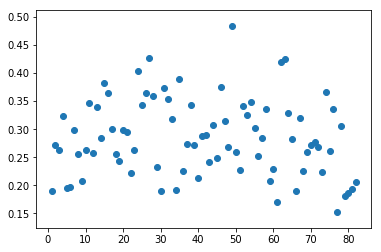

In [645]:
plt.scatter(gini_bos_1986['g_num'], gini_bos_1986['gini_7'])
plt.show()

In [648]:
min(gini_bos_1986['gini_7'])

0.151657683311299

## Creating average Gini score per year

In [650]:
gini_avgs = pd.DataFrame()
for link in links:
    gini_log = pd.read_excel(link)
    yr = int(link[26:30])
    for team in np.unique(gini_log['team']):
        temp_df = gini_log[gini_log['team'] == team]
        avg_gini_2 = np.mean(temp_df['gini_2'])
        avg_gini_3 = np.mean(temp_df['gini_3'])
        avg_gini_4 = np.mean(temp_df['gini_4'])
        avg_gini_5 = np.mean(temp_df['gini_5'])
        avg_gini_6 = np.mean(temp_df['gini_6'])
        avg_gini_7 = np.mean(temp_df['gini_7'])
        avg_gini_8 = np.mean(temp_df['gini_8'])
        avg_gini_9 = np.mean(temp_df['gini_9'])
        avg_gini_10 = np.mean(temp_df['gini_10'])
        #print team, avg_gini
        gini_avgs = gini_avgs.append({'team': team,
                                      'season': yr,
                                      'avg_gini_2': avg_gini_2,
                                      'avg_gini_3': avg_gini_3,
                                      'avg_gini_4': avg_gini_4,
                                      'avg_gini_5': avg_gini_5,
                                      'avg_gini_6': avg_gini_6,
                                      'avg_gini_7': avg_gini_7,
                                      'avg_gini_8': avg_gini_8,
                                      'avg_gini_9': avg_gini_9,
                                      'avg_gini_10': avg_gini_10
                                     }, 
                                      ignore_index=True)

In [651]:
gini_avgs

,avg_gini_10,avg_gini_2,avg_gini_3,avg_gini_4,avg_gini_5,avg_gini_6,avg_gini_7,avg_gini_8,avg_gini_9,season,team
0,0.389127,0.249990,0.250331,0.257955,0.267611,0.282357,0.302350,0.326311,0.357421,1986.0,ATL
1,0.408119,0.111285,0.138011,0.169185,0.209919,0.248315,0.285153,0.323832,0.368127,1986.0,BOS
2,0.364538,0.121140,0.143421,0.169679,0.196103,0.226368,0.257876,0.293265,0.330643,1986.0,CHI
3,0.362779,0.109581,0.142430,0.171257,0.198138,0.230159,0.260809,0.291594,0.326148,1986.0,CLE
4,0.370570,0.103957,0.145813,0.169093,0.191338,0.221437,0.255052,0.294524,0.339404,1986.0,DAL
5,0.382185,0.171780,0.180792,0.196857,0.217971,0.244176,0.271422,0.306938,0.346790,1986.0,DEN
6,0.344066,0.093509,0.118941,0.142933,0.172247,0.202161,0.234007,0.268761,0.310082,1986.0,DET
7,0.410905,0.103261,0.138659,0.173737,0.210661,0.249304,0.287163,0.328560,0.374768,1986.0,GSW
8,0.363503,0.124895,0.138923,0.155369,0.182267,0.212362,0.246784,0.287603,0.331490,1986.0,HOU
9,0.344150,0.112898,0.128987,0.145121,0.164128,0.189241,0.219341,0.258479,0.303615,1986.0,IND


In [652]:
gini_avgs.to_excel('data/gini_avgs.xlsx')

In [653]:
s_res = pd.read_excel('data/nba_results.xlsx')

In [654]:
s_res.head(n=20)

,Team,W,L,WL_pct,PW,PL,PS/G,PA/G,yr,abbr,playoffs
0,Boston Celtics,53,29,0.646,48,34,108.0,105.4,2017,BOS,3
1,Cleveland Cavaliers,51,31,0.622,49,33,110.3,107.2,2017,CLE,4
2,Toronto Raptors,51,31,0.622,52,30,106.9,102.6,2017,TOR,2
3,Washington Wizards,49,33,0.598,46,36,109.2,107.4,2017,WAS,2
4,Atlanta Hawks,43,39,0.524,39,43,103.2,104.0,2017,ATL,1
5,Milwaukee Bucks,42,40,0.512,40,42,103.6,103.8,2017,MIL,1
6,Indiana Pacers,42,40,0.512,40,42,105.1,105.3,2017,IND,1
7,Chicago Bulls,41,41,0.500,42,40,102.9,102.4,2017,CHI,1
8,Miami Heat,41,41,0.500,44,38,103.2,102.1,2017,MIA,0
9,Detroit Pistons,37,45,0.451,38,44,101.3,102.5,2017,DET,0


In [657]:
len(s_res) == len(gini_avgs)

True

In [661]:
temp = gini_avgs[(gini_avgs['team'] == 'BOS') & (gini_avgs['season'] == 2017)]

In [670]:
temp['avg_gini_2'].values[0]

0.18873408514237933

In [672]:
gini_lst_2 = []
gini_lst_3 = []
gini_lst_4 = []
gini_lst_5 = []
gini_lst_6 = []
gini_lst_7 = []
gini_lst_8 = []
gini_lst_9 = []
gini_lst_10 = []
for i in range(len(s_res)):
    #print i
    temp = gini_avgs[(gini_avgs['team'] == str(s_res.iloc[i].abbr)) & (gini_avgs['season'] == s_res.iloc[i].yr)]
    gini_lst_2.append(temp['avg_gini_2'].values[0])
    gini_lst_3.append(temp['avg_gini_3'].values[0])
    gini_lst_4.append(temp['avg_gini_4'].values[0])
    gini_lst_5.append(temp['avg_gini_5'].values[0])
    gini_lst_6.append(temp['avg_gini_6'].values[0])
    gini_lst_7.append(temp['avg_gini_7'].values[0])
    gini_lst_8.append(temp['avg_gini_8'].values[0])
    gini_lst_9.append(temp['avg_gini_9'].values[0])
    gini_lst_10.append(temp['avg_gini_10'].values[0])

In [674]:
gini_lst_5

[0.2283262251548577,
 0.27299046452782827,
 0.25865104542251388,
 0.23426005055238927,
 0.17218038319021489,
 0.22081072819059183,
 0.19535751057365111,
 0.20261444546597807,
 0.16123983280879414,
 0.13055159552188217,
 0.19613794419845057,
 0.21491279589639742,
 0.13881963807924372,
 0.14244022607576809,
 0.17779811377661997,
 0.25876184960126491,
 0.22523410436664504,
 0.25093076987600155,
 0.17408358154159612,
 0.16800148100113774,
 0.32530533166421627,
 0.18959323597611707,
 0.24621380843500423,
 0.13807193838168227,
 0.24927079993805937,
 0.17452640570047515,
 0.22717358823346354,
 0.24771716617651343,
 0.15871027271645807,
 0.22972200266102055,
 0.24246851770874694,
 0.2368894165807722,
 0.18265935078492485,
 0.15228070462077745,
 0.19086499938403229,
 0.16756453188029205,
 0.21236589632657568,
 0.15265703657443347,
 0.20832144885524329,
 0.20148301203669869,
 0.15555568011165818,
 0.15553764540694029,
 0.21109239469302188,
 0.17215042660442889,
 0.16764294455957168,
 0.263400086

In [675]:
s_res['avg_gini_2'] = gini_lst_2
s_res['avg_gini_3'] = gini_lst_3
s_res['avg_gini_4'] = gini_lst_4
s_res['avg_gini_5'] = gini_lst_5
s_res['avg_gini_6'] = gini_lst_6
s_res['avg_gini_7'] = gini_lst_7
s_res['avg_gini_8'] = gini_lst_8
s_res['avg_gini_9'] = gini_lst_9
s_res['avg_gini_10'] = gini_lst_10

In [676]:
s_res.head()

,Team,W,L,WL_pct,PW,PL,PS/G,PA/G,yr,abbr,playoffs,avg_gini_2,avg_gini_3,avg_gini_4,avg_gini_5,avg_gini_6,avg_gini_7,avg_gini_8,avg_gini_9,avg_gini_10
0,Boston Celtics,53,29,0.646,48,34,108.0,105.4,2017,BOS,3,0.188734,0.197474,0.211538,0.228326,0.250016,0.274372,0.302357,0.337142,0.371904
1,Cleveland Cavaliers,51,31,0.622,49,33,110.3,107.2,2017,CLE,4,0.081886,0.163090,0.234685,0.272990,0.304655,0.331081,0.361622,0.396819,0.425868
2,Toronto Raptors,51,31,0.622,52,30,106.9,102.6,2017,TOR,2,0.166043,0.217087,0.239159,0.258651,0.278967,0.304124,0.331967,0.367686,0.402208
3,Washington Wizards,49,33,0.598,46,36,109.2,107.4,2017,WAS,2,0.110757,0.167674,0.206557,0.234260,0.264020,0.294161,0.329003,0.369293,0.399838
4,Atlanta Hawks,43,39,0.524,39,43,103.2,104.0,2017,ATL,1,0.086902,0.117028,0.145800,0.172180,0.202079,0.231692,0.264721,0.299523,0.335840


In [677]:
team = 'ATL'
yr = 1986
print gini_avgs[(gini_avgs['team'] == team) & (gini_avgs['season'] == yr)]
print s_res[(s_res['abbr'] == team) & (s_res['yr'] == yr)]

   avg_gini_10  avg_gini_2  avg_gini_3  avg_gini_4  avg_gini_5  avg_gini_6  \
0     0.389127     0.24999    0.250331    0.257955    0.267611    0.282357   

   avg_gini_7  avg_gini_8  avg_gini_9  season team  
0     0.30235    0.326311    0.357421  1986.0  ATL  
              Team   W   L  WL_pct  PW  PL   PS/G   PA/G    yr abbr  playoffs  \
890  Atlanta Hawks  50  32    0.61  47  35  108.6  106.2  1986  ATL         2   

     avg_gini_2  avg_gini_3  avg_gini_4  avg_gini_5  avg_gini_6  avg_gini_7  \
890     0.24999    0.250331    0.257955    0.267611    0.282357     0.30235   

     avg_gini_8  avg_gini_9  avg_gini_10  
890    0.326311    0.357421     0.389127  


In [678]:
s_res.to_excel('data/nba_results_with_ginis.xlsx')

In [679]:
s_res_recent = s_res[s_res['yr'] >= 2008]
s_res_past = s_res[s_res['yr'] < 2008]

In [702]:
zip(s_res[s_res['playoffs'] == 5]['Team'], s_res[s_res['playoffs'] == 5]['avg_gini_5'])

[(u'Golden State Warriors', 0.2587618496012649),
 (u'Cleveland Cavaliers', 0.24246851770874694),
 (u'Golden State Warriors', 0.20961844188335285),
 (u'San Antonio Spurs', 0.1522921388778918),
 (u'Miami Heat', 0.2551595736220979),
 (u'Miami Heat', 0.27834694965506046),
 (u'Dallas Mavericks', 0.18901499595421323),
 (u'Los Angeles Lakers', 0.24791271137297713),
 (u'Los Angeles Lakers', 0.24532255552907214),
 (u'Boston Celtics', 0.1920618736720993),
 (u'San Antonio Spurs', 0.2242572324837512),
 (u'Miami Heat', 0.26219768199589244),
 (u'San Antonio Spurs', 0.22528159805812542),
 (u'Detroit Pistons', 0.1730667518403661),
 (u'San Antonio Spurs', 0.2229944459672993),
 (u'Los Angeles Lakers', 0.306131337919359),
 (u'Los Angeles Lakers', 0.33139365424999695),
 (u'Los Angeles Lakers', 0.3014044611375033),
 (u'San Antonio Spurs', 0.21153553897881155),
 (u'Chicago Bulls', 0.30524302839171835),
 (u'Chicago Bulls', 0.3018511407663125),
 (u'Chicago Bulls', 0.30215885807932663),
 (u'Houston Rockets', 0

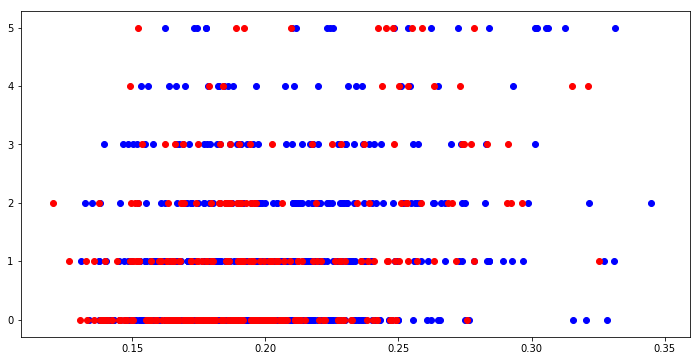

In [701]:
plt.figure(figsize=(12,6))
plt.scatter(s_res_past['avg_gini_5'], s_res_past['playoffs'], c='b')
plt.scatter(s_res_recent['avg_gini_5'], s_res_recent['playoffs'], c='r')
plt.show()

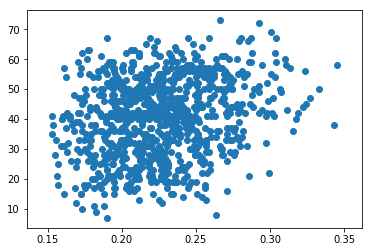

In [394]:
plt.scatter(s_res['avg_gini'], s_res['W'])
plt.show()

In [492]:
s2017 = s_res[s_res['yr'] == 2014]

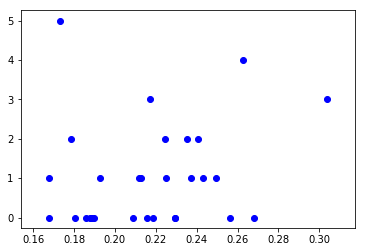

In [493]:
plt.scatter(s2017['avg_gini'], s2017['playoffs'], c='b')
plt.show()